# Quantum Tunneling

In this notebook, the goal is to understand how quantum tuneling simulations can be implemented in Qiskit. In order to do so, we will first discuss time evolution and the Suzuki-Trotter formula. We will then discuss how to implement these operators on a quantum computer as a quantum circuit. Working knowledge of the quantum fourier transform (QFT) is assumed.


## Time Evolution

In quantum mechanics, it is reasonable to ask: given a state $|\psi (x,t)\rangle $, what will be the wavefunction at some later time, $\Delta t$. That is, what is $| \psi(x, t + \delta t) \rangle$.  

The wave function must satisfy the time dependent Schrodinger equation:

$$ i \frac{\partial }{\partial t} |\psi(x,t) \rangle = \hat{H} | \psi (x,t) \rangle $$

We have set $\hbar = 1$ for simplicity. Assume that the time dependence is strictly contained in the wavefunction, meaning that our Hamiltonian is time independent. Let's further assume that we can break our Hamiltonian down into a Kinetic and a Potential term:

$$ \hat{H} = \hat{K} + \hat{V} $$

where $\hat{K}$ is the kinetic term and $\hat{V}$ is the potential term. Note that many Hamiltonians we have seen in Quantum l and Quantum ll take this form: the free particle, well potentials, the harmonic oscillator, etc. 

Given these assumptions, we can simply express time evolution as an exponential operator applied to the wavefuntion at a previous time. That is:

$$ | \psi(x, t + \Delta t) \rangle = e^{-i\hat{H}\Delta t} | \psi(x, t )\rangle = e^{-i(\hat{K} + \hat{V})\Delta t} | \psi(x, t ) \rangle $$


### Suzuki-Trotter Formula
<font color='red'>Add proof of this formula later</font>

In general, matrix exponentials can be quite complicated, especially when we are exponentiating a sum of operators. However, we can take the first order Suzuki-Trotter approximation to simplify:

$$ e^{-i(\hat{K}+\hat{V})\Delta t} \approx e^{-i\hat{K}\Delta t}e^{-i \hat{V} \Delta t}$$

Note that the above is an equality if $[\hat{K}, \hat{V}] = 0 $. 

## Mapping the Problem to a Quantum Circuit

We now have almost all the ammunition to map this problem onto a quantum circuit. In order to simulate time evolution on a quantum computer, we would need a way to initialize the initial state, apply the time evolution, and then measure the resulting state. To create the initial state, we choose a representation in which the position space, bounded by some interval $[0, L]$, is discretizes into segments. Potentials for the time evolution will be applied as single qubit Z-rotations. To implement the time evolution proportional to the kinetic term, we use the Quantum Fourier Transform (QFT) to work in momentum space. 

### Discretization of Space 

Representing continuous space in a quantum circuit may initially not be very obvious. The way we do so for this simulation is the following. Our goal is to map this problem to some $n$-qubit circuit. Consider a spatial interval of length $L$, given by $[0, L]$. Further assume that we have periodic boundary conditions on the wave function. That is: $ | \psi(x, t) \rangle = | \psi(x + L, t) \rangle$. 

We can fix some interval, $\Delta l = L / 2^n$. We can express the wavefunction as so:

$$  | \psi (x, t) \rangle = \sum_{k=0}^{2^n - 1} \psi (x_k, t) | k \rangle$$

where $x_k = (k + \frac{1}{2}) \Delta l$. In the quantum circuits, express $| k \rangle$ in binary. The best way to see how this works is by example. 

Consider a case in which we discretize our space using $n=3$ qubits. Then, our space will be discretized into four intervals. We can express our wavefunction as:

$$ | \psi (x, t) \rangle = \psi (x_0, t) | 00 \rangle + \psi (x_1, t) | 01 \rangle +\psi (x_2, t) | 10 \rangle + \psi (x_3, t) | 11 \rangle$$ 

Note that the $k$ value in the kets correspond to the same $k$ that subscript the $x$. ($1 = 1$ in binary, $2 = 10$ in binary, etc.) 

### Applying Potentials
<font color='red'> finish later </font>

# Quantum Tunelling Implementation

This notebook will start with the simple case of two qubits. Note that this means we have $n=2$, so we have discretized the space into $2^2 = 4$ sections: $|00 \rangle, |01 \rangle, |10 \rangle, |11 \rangle$.  

In [1]:
import numpy as np
import numpy.linalg as la
import math as m
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
#from qiskit_textbook.tools import random_state, array_to_latex # This import isn't working for me

import qiskit
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.14.1', 'qiskit-aer': '0.5.2', 'qiskit-ignis': '0.3.0', 'qiskit-ibmq-provider': '0.7.2', 'qiskit-aqua': '0.7.1', 'qiskit': '0.19.3'}


# Aden's Notes

(The following image is taken from Aden's slides)

Our goal is the produce the following gate into a circuit:

<img src="Tunelling Images/kinetic gate.png">


The matrix above represents our kinetic time evolution operator once we are in the QFTed basis. This kinetic term can be broken down into the following gates.

<img src="Tunelling Images/gates.png">

Note that the first and the last block of gates is simply the quantum fourier transforms and inverses.

**Although Qiskit does numbering in the opposite order (0 on the top row, then 1, then 2, etc.) I will follow this picture exactly.**

<img src="Tunelling Images/3 decomp.png">


<img src="Tunelling Images/D gate.png">

We will first try the case with $\Delta t = 1/\pi \approx 0.318$. Then, we can use the values given above

In [2]:
#I will start by defining functions for the quantum fourier transform (and inverse), potential, and D term
# in the image above, 1 -> 1, and 2 -> 0

# Setting th parameters for the system
delta_t = 3 / 10 
#I checked 2/10, 3/10, and 5/10
theta1 = -m.pi*m.pi*delta_t
theta2 = -m.pi*m.pi*delta_t/4
theta3 = m.pi*m.pi*delta_t

def F(qc):
    qc.h(1)
    qc.cu1(m.pi/2, 0, 1)
    qc.h(0)
    qc.barrier()
    return qc

def F_inv(qc):
    qc.h(0)
    qc.cu1(-m.pi/2, 0, 1)
    qc.h(1)
    qc.barrier()
    return qc    

def D(qc, theta1, theta2, theta3):
    qc.rz(theta1, 0)
    qc.rz(theta2, 1)
    qc.cu1(theta3, 1,0)
    qc.barrier()
    return qc
    


In [3]:
# Using Aden's notes, I will try a free particle simulation

# Initializing the circuit
qr = QuantumRegister(2) #the qubits needed
cr = ClassicalRegister(2) #for the measurement
qc = QuantumCircuit(qr, cr) #creating the quantum circuit
qc.x(0)
F(qc)
D(qc, theta1, theta2, theta3)
F_inv(qc)
qc.measure( qr , cr )

qc.draw()

┌───┐       ┌───┐ ░ ┌─────────────┐           ░ ┌───┐              ░ ┌─┐»
q0_0: ┤ X ├─■─────┤ H ├─░─┤ RZ(-2.9609) ├──■────────░─┤ H ├─■────────────░─┤M├»
      ├───┤ │pi/2 └───┘ ░ ├─────────────┴┐ │2.9609  ░ └───┘ │-pi/2 ┌───┐ ░ └╥┘»
q0_1: ┤ H ├─■───────────░─┤ RZ(-0.74022) ├─■────────░───────■──────┤ H ├─░──╫─»
      └───┘             ░ └──────────────┘          ░              └───┘ ░  ║ »
c0_0: ══════════════════════════════════════════════════════════════════════╩═»
                                                                              »
c0_1: ════════════════════════════════════════════════════════════════════════»
                                                                              »
«         
«q0_0: ───
«      ┌─┐
«q0_1: ┤M├
«      └╥┘
«c0_0: ═╬═
«       ║ 
«c0_1: ═╩═
«

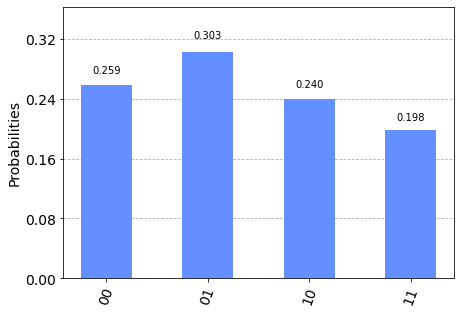

In [4]:

backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
counts = execute(qc, backend, shots=1024).result().get_counts()

"""
vector = np.zeros(len(counts))

ordering = {'00': 0, '01': 1, '10':2, '11':3}
for key in counts.keys():
    print(key) #printing the key to check the order
    vector[ordering[key]] = counts[key]
    
vector = vector / 1024
print(vector)

density_matrix = np.outer(vector, vector)
print(density_matrix)
"""

plot_histogram(counts)

## Implementing V

We will now try to implent a potential operator. Recall that:

$$ R_\phi = \begin{bmatrix} 1 & 0 \\ 0 & e^{i\phi}\end{bmatrix} $$

We know that we can write the potential operator as:

<img src="Tunelling Images/V gate.png">

Consider the operation $ I \otimes R_\phi $

$$ I \otimes R_\phi = \begin{bmatrix}  1 & 0 \\ 0 & 1 \end{bmatrix}\otimes \begin{bmatrix}  1 & 0 \\ 0 & e^{i\phi}\end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & e^{i\phi} & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\phi}\end{bmatrix}$$

We can allow for a shift by a global phase, so by setting $\phi = 2V_0 \Delta t$, we effectively achieve the potential shown. This would be equivalent to having peaks in the $|01 \rangle, |11 \rangle$ spots.

In [55]:
# We will now try this using a potential

# Using Aden's notes, I will try a free particle simulation

def V(qc, v_0, delta_t):
    qc.rz(2*v_0*delta_t, 0) # check to make sure you're applying this to the correct place
    qc.barrier()
    return qc

def apply_evo(qc, v_0, delta_t, theta1, theta2, theta3):
    F(qc)
    D(qc, theta1, theta2, theta3)
    F_inv(qc)
    V(qc, v_0, delta_t)
    qc.barrier()
    return qc

delta_t = 1 / 10
theta1 = -m.pi*m.pi*delta_t
theta2 = -m.pi*m.pi*delta_t/4
theta3 = m.pi*m.pi*delta_t
time_steps = 5
v_0 = 10



# Initializing the circuit
qr = QuantumRegister(2) #the qubits needed
cr = ClassicalRegister(2) #for the measurement
qc2 = QuantumCircuit(qr, cr) #creating the quantum circuit
qc2.x(0)

qc2.barrier()
i = 0
while i < time_steps:
    apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
    i+=1
    
qc2.measure( qr , cr )

#qc2.draw()

# NOTE::
#for v0 = 100. dt = 1/5, 10 steps, results look a bit funny

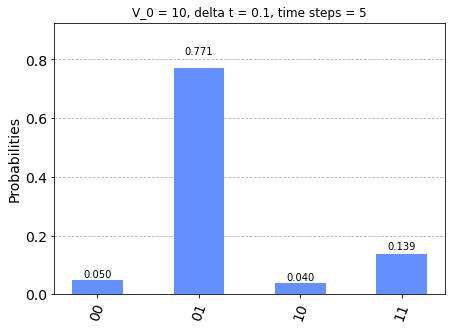

In [56]:

backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
counts2 = execute(qc2, backend, shots=1024).result().get_counts()


plot_histogram(counts2, title = "V_0 = " + str(v_0) + ", delta t = " + str(delta_t) + ", time steps = " + str(time_steps))

## Results

Let's look at 1, 5, and 9 time steps. Here are the resulting histograms:
<img src="Tunelling Images/step1.png">
<img src="Tunelling Images/step5.png">
<img src="Tunelling Images/step9.png">

For comparison, here is a graph from the nature paper:

<img src="Tunelling Images/nature theoretical prediction.png">

Notice that our data aligns for these steps!

## Analysis on the Suzuki-Trotter Approximation

Note that our time evolution term takes the form:

$$ e^{-iHt} = e^{-i(K+V)t} $$

We approximated this term by taking:

$$ e^{-i(K+V)t} \approx e^{-iKt} e^{-iVt} $$

Let's try to understand this approximation slightly better. 

To be completely correct, the expansion of our sum of operators takes the form:

$$ e^{-i(K+V)t} = 1 + (-it)(K+V) + \frac{1}{2}(-it)^2(K+V)^2 + O(t^3) = 1 + (-it)(K+V) + \frac{1}{2}(-it)^2[K^2 + KV + VK + V^2] + O(t^3)$$

The approximation we use can be expanded out as:
$$ e^{-iKt}e^{-iVt} = (1 + (-it)K + \frac{1}{2}(-it)^2K^2 + ... )(1 + (-it)V + \frac{1}{2}(-it)^2V^2 + ... ) = 1 + (-it)(K+V) + \frac{1}{2}(-it)^2(K^2 + 2KV + V^2) + O(t^3) $$  


We notice that, to 3rd order in $t$, we find that:

$$ e^{-iKt}e^{-iVt} = e^{-i(K+V)t + \frac{1}{2} (-it)^2[K, V] + O(t^3} $$

The implication here is that $ e^{-i(K+V)t} \approx e^{-iKt} e^{-iVt} $ is a good approximation if $\frac{1}{2} (-it)^2[K, V]$ is small. This has two further implications: it's important to keep $t$, or in our case, $\Delta t$, small. However, we should also recognize that $[K,V]$ must be smalll as well. 

#### Ref for this:

https://arxiv.org/pdf/math-ph/0506007.pdf

https://arxiv.org/pdf/1912.08854.pdf

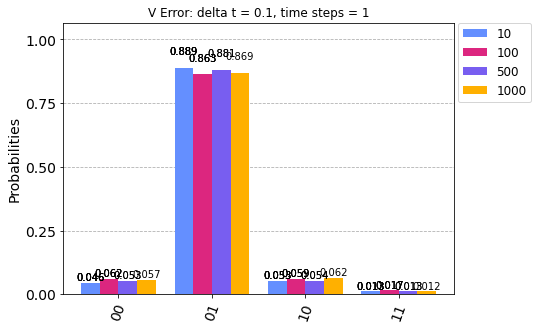

In [44]:
# In the cells below, we analyze error in trotterization

## In this cell, we analyze v_0 = 10, 100, 1000 for 1 and 5 time steps
delta_t = 1 / 10
time_steps = 1
v_0_array = np.array([10, 100, 500, 1000])


for v_0 in v_0_array:
    # Initializing the circuit
    qr = QuantumRegister(2) #the qubits needed
    cr = ClassicalRegister(2) #for the measurement
    qc2 = QuantumCircuit(qr, cr) #creating the quantum circuit
    qc2.x(0)
    qc2.barrier()
    
    i = 0
    
    while i < time_steps:
        apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
        i+=1
    
    
    qc2.measure( qr , cr )
    #print(qc2.draw())
    backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
    counts2 = execute(qc2, backend, shots=1024).result().get_counts()
    exec("counts2_%s=counts2" % v_0)
legend = ['10', '100', '500', '1000']
plot_histogram([counts2_10, counts2_100, counts2_500, counts2_1000],
                title = "V Error: delta t = " + str(delta_t) + ", time steps = " + str(time_steps), legend=legend)

    
    

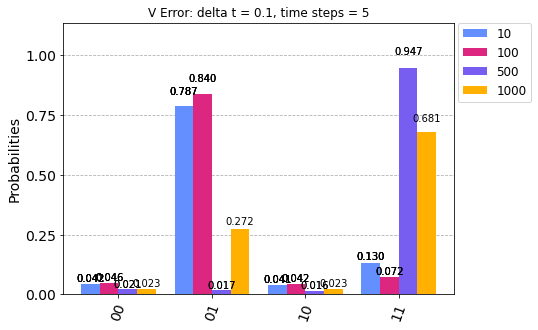

In [45]:
# In the cells below, we analyze error in trotterization

## In this cell, we analyze v_0 = 10, 100, 1000 for 1 and 5 time steps
delta_t = 1 / 10
time_steps = 5
v_0_array = np.array([10, 100, 500, 1000])


for v_0 in v_0_array:
    # Initializing the circuit
    qr = QuantumRegister(2) #the qubits needed
    cr = ClassicalRegister(2) #for the measurement
    qc2 = QuantumCircuit(qr, cr) #creating the quantum circuit
    qc2.x(0)
    qc2.barrier()
    
    i = 0
    
    while i < time_steps:
        apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
        i+=1
    
    
    qc2.measure( qr , cr )
    #print(qc2.draw())
    backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
    counts2 = execute(qc2, backend, shots=1024).result().get_counts()
    exec("counts2_%s=counts2" % v_0)
legend = ['10', '100', '500', '1000']
plot_histogram([counts2_10, counts2_100, counts2_500, counts2_1000],
                title = "V Error: delta t = " + str(delta_t) + ", time steps = " + str(time_steps), legend=legend)

    
    

## Conclusion on V Error

It seems like for large V, we have faster oscillations. 
I don't quite understand why we get the pattern above. I checked this against the above, using just $V_0=500$ and 5 time steps, and this seems to agree. This is worth asking about since I don't quite get it. I expected greater V to be more rigid

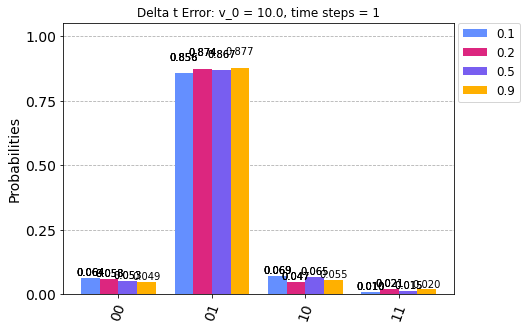

In [50]:
# Analysis of delta t error.

# In the cells below, we analyze error in trotterization

## In this cell, we analyze v_0 = 10, 100, 1000 for 1 and 5 time steps
delta_t_array = np.array([0.1, 0.2, 0.5, 0.9])
time_steps = 1
v_0 = 10.

counter = 0
for delta_t in delta_t_array:
    # Initializing the circuit
    qr = QuantumRegister(2) #the qubits needed
    cr = ClassicalRegister(2) #for the measurement
    qc2 = QuantumCircuit(qr, cr) #creating the quantum circuit
    qc2.x(0)
    qc2.barrier()
    
    i = 0
    
    while i < time_steps:
        apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
        i+=1
    
    
    qc2.measure( qr , cr )
    #print(qc2.draw())
    backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
    counts2 = execute(qc2, backend, shots=1024).result().get_counts()
    exec("counts2_%s=counts2" % counter)
    counter += 1
    
legend = ['0.1', '0.2', '0.5', '0.9']
plot_histogram([counts2_0, counts2_1, counts2_2, counts2_3],
                title = "Delta t Error: v_0 = " + str(v_0) + ", time steps = " + str(time_steps), legend=legend)

    
    


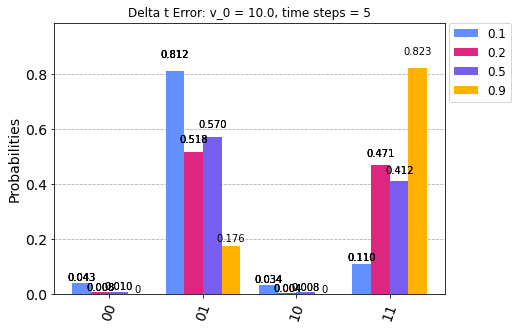

In [51]:
# Analysis of delta t error.

# In the cells below, we analyze error in trotterization

## In this cell, we analyze v_0 = 10, 100, 1000 for 1 and 5 time steps
delta_t_array = np.array([0.1, 0.2, 0.5, 0.9])
time_steps = 5
v_0 = 10.

counter = 0
for delta_t in delta_t_array:
    # Initializing the circuit
    qr = QuantumRegister(2) #the qubits needed
    cr = ClassicalRegister(2) #for the measurement
    qc2 = QuantumCircuit(qr, cr) #creating the quantum circuit
    qc2.x(0)
    qc2.barrier()
    
    i = 0
    
    while i < time_steps:
        apply_evo(qc2, v_0, delta_t, theta1, theta2, theta3)
        i+=1
    
    
    qc2.measure( qr , cr )
    #print(qc2.draw())
    backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
    counts2 = execute(qc2, backend, shots=1024).result().get_counts()
    exec("counts2_%s=counts2" % counter)
    counter += 1
    
legend = ['0.1', '0.2', '0.5', '0.9']
plot_histogram([counts2_0, counts2_1, counts2_2, counts2_3],
                title = "Delta t Error: v_0 = " + str(v_0) + ", time steps = " + str(time_steps), legend=legend)

    
    


## References

https://www.nature.com/articles/srep02232.pdf

https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

https://arxiv.org/pdf/1712.07326.pdf

Aden Lam's Notes

## Sandbox for things

In [27]:
value = 20
exec("var%s=value" % 1)
print(var1)

20


## TRying https://arxiv.org/pdf/1202.1536.pdf

